# Analysis of Protein Structure Prediction Results

## Colab Setup

1. Check the runtime instance
2. Choose whether to use Google Drive (persistence) or temp `/content`
3. Install required Python packages
4. Get course files/data into the runtime
5. Mount Google Drive for persistent storage


## 1) Check the runtime


In [3]:
import sys, platform, os, textwrap
print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())
print("Working dir:", os.getcwd())


Python: 3.12.12
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Working dir: /content


In [4]:
!arch

x86_64


## 2) Choose whether to use Google Drive (persistence)

- If you want your edits to persist across sessions, use **Drive**.
- If you're just running a quick exercise, you can skip Drive and use the temporary Colab filesystem (`/content`).


In [38]:
USE_DRIVE = True  # set False if you want to skip Drive mounting

if USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Drive mounted at /content/drive")
else:
    print("Skipping Drive mount.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive mounted at /content/drive


In [39]:
import os
from pathlib import Path

# Change this folder name once; everything else uses it.
COURSE_DIR_NAME = "structbio_course"  # you can rename for your course

if "drive" in str(Path("/content/drive")) and os.path.exists("/content/drive") and USE_DRIVE:
    ROOT = Path("/content/drive/MyDrive") / COURSE_DIR_NAME
else:
    ROOT = Path("/content") / COURSE_DIR_NAME

ROOT.mkdir(parents=True, exist_ok=True)

DATA_DIR = ROOT / "data"
(DATA_DIR).mkdir(exist_ok=True)

OUTPUTS_DIR = ROOT / "outputs"
(OUTPUTS_DIR).mkdir(exist_ok=True)

print("ROOT:", ROOT)
print("data:", DATA_DIR)
print("outputs:", OUTPUTS_DIR)


ROOT: /content/drive/MyDrive/structbio_course
data: /content/drive/MyDrive/structbio_course/data
outputs: /content/drive/MyDrive/structbio_course/outputs


## 2) Get a copy of the AF2, AF3 and ESMFold results that we will analyze

... and unzip the archive


In [47]:
import os, pathlib, urllib.request

RAW_URL = "https://raw.githubusercontent.com/vvoelz/chem5412-spring2026/main/data/assignment01.zip"
zip_path = pathlib.Path(DATA_DIR) / "assignment01.zip"

urllib.request.urlretrieve(RAW_URL, zip_path)
print("Saved to:", zip_path)

!unzip {zip_path}
!cp assignment01 {DATA_DIR}

print(f'Unzipped folder `assignment01` moved to {DATA_DIR}')

Saved to: /content/drive/MyDrive/structbio_course/data/assignment01.zip
Archive:  /content/drive/MyDrive/structbio_course/data/assignment01.zip
replace assignment01/ESMFold_demo/ESMFold.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: assignment01/ESMFold_demo/ESMFold.ipynb  
  inflating: assignment01/ESMFold_demo/T1027_CASP14_VAV_3b382/ptm0.444_r3_default.pdb  
  inflating: assignment01/ESMFold_demo/T1027_CASP14_VAV_3b382/ptm0.444_r3_default.pae.txt  
  inflating: assignment01/ESMFold_demo/T1027_CASP14_VAV_3b382/ptm0.444_r3_default.png  
 extracting: assignment01/ESMFold_demo/README.md  
 extracting: assignment01/ESMFold_demo/T1027_CASP14_VAV_3b382.zip  
 extracting: assignment01/AF3_demo/README.md  
  inflating: assignment01/AF3_demo/fold_vav_2026_01_31_15_42/fold_vav_2026_01_31_15_42_summary_confidences_1.json  
  inflating: assignment01/AF3_demo/fold_vav_2026_01_31_15_42/msas/fold_vav_2026_01_31_15_42_paired_msa_chains_a.a3m  
  inflating: assignment01/AF3_demo/fold_vav_

## 3) Get the experimental PDB file

We'll need the following packages:

In [26]:
!pip -q install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 26.7 MB/s eta 0:00:00


In [48]:
from Bio.PDB import PDBParser, PDBIO, Select
import requests
from pathlib import Path

# ---- paths ----
WORK_DIR = pathlib.Path(DATA_DIR) / "assignment01"
# This should exist if cells above are successful

pdb_id = "7D2O"
full_pdb = WORK_DIR / f"{pdb_id}_full.pdb"
model1_pdb = WORK_DIR / f"{pdb_id}_model1.pdb"

# ---- download ----
url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
resp = requests.get(url, timeout=30)
resp.raise_for_status()
full_pdb.write_text(resp.text)

print("Downloaded:", full_pdb)

# ---- select only MODEL 1 ----
class ModelSelect(Select):
    def accept_model(self, model):
        return model.id == 0   # MODEL 1 → id == 0 in Biopython

parser = PDBParser(QUIET=True)
structure = parser.get_structure(pdb_id, str(full_pdb))

io = PDBIO()
io.set_structure(structure)
io.save(str(model1_pdb), select=ModelSelect())

print("Saved MODEL 1 only to:", model1_pdb)


Downloaded: /content/drive/MyDrive/structbio_course/data/assignment01/7D2O_full.pdb
Saved MODEL 1 only to: /content/drive/MyDrive/structbio_course/data/assignment01/7D2O_model1.pdb


In [51]:
!head -20 {model1_pdb}

MODEL      1
ATOM      1  N   LYS A   1      -3.395   9.371  24.583  1.00  0.00          N  
ATOM      2  CA  LYS A   1      -2.630   9.369  23.342  1.00  0.00          C  
ATOM      3  C   LYS A   1      -1.521   8.323  23.388  1.00  0.00          C  
ATOM      4  O   LYS A   1      -1.115   7.860  24.455  1.00  0.00          O  
ATOM      5  CB  LYS A   1      -2.029  10.754  23.088  1.00  0.00          C  
ATOM      6  CG  LYS A   1      -2.892  11.638  22.204  1.00  0.00          C  
ATOM      7  CD  LYS A   1      -3.009  13.045  22.767  1.00  0.00          C  
ATOM      8  CE  LYS A   1      -4.411  13.322  23.288  1.00  0.00          C  
ATOM      9  NZ  LYS A   1      -4.390  14.151  24.525  1.00  0.00          N  
ATOM     10  H   LYS A   1      -2.918   9.371  25.439  1.00  0.00          H  
ATOM     11  HA  LYS A   1      -3.305   9.125  22.536  1.00  0.00          H  
ATOM     12  HB2 LYS A   1      -1.891  11.253  24.035  1.00  0.00          H  
ATOM     13  HB3 LYS A   1 

## 4) Compute per-residue LDDT scores of predictd structures, using the experimental structure as the reference

### AlphaFold2 predictions

The code below will compute the *actual* LDDT.

The *predicted* pLDDT scores are stored in `AF2_demo/prediction_1/best_model_pae.json`

In [64]:
!pip -q install biotite

import numpy as np
import biotite.structure as struc
import biotite.structure.io.pdb as pdb
import biotite.sequence as seq
import biotite.sequence.align as align

def read_pdb_as_atoms(pdb_path, model=1):
    """
    Read a PDB file into a Biotite AtomArray.
    model=1 means 'MODEL 1' (Biotite uses 1-based model index here).
    """
    f = pdb.PDBFile.read(pdb_path)
    atoms = f.get_structure(model=model)
    # Keep amino acids only (drop waters/ions/ligands)
    atoms = atoms[struc.filter_amino_acids(atoms)]
    return atoms

ref_path   =  model1_pdb     # <-- your experimental PDB
model_path = WORK_DIR / f"AF2_demo/prediction_1/best_model.pdb"   # <-- your predicted PDB

reference = read_pdb_as_atoms(ref_path, model=1)
model     = read_pdb_as_atoms(model_path, model=1)

# --- Build sequences from structures ---
ref_seq   = struc.to_sequence(reference)[0][0]
model_seq = struc.to_sequence(model)[0][0]

# --- Align sequences to find overlap (robust to differing residue numbering) ---
# Use an identity matrix to avoid "creative" substitutions; good for same protein / close homologs
identity = align.SubstitutionMatrix(
    seq.ProteinSequence.alphabet,
    seq.ProteinSequence.alphabet,
    np.eye(len(seq.ProteinSequence.alphabet), dtype=int),
)

aln = align.align_optimal(
    ref_seq,
    model_seq,
    identity,
    gap_penalty=-1,
    terminal_penalty=False,
    max_number=1,
)[0]

# Keep only aligned columns with residue-residue correspondence (drop gaps)
aln = aln[(aln.trace != -1).all(axis=1)]

# Map alignment columns -> residue indices, then -> atom masks
ref_starts   = struc.get_residue_starts(reference)
model_starts = struc.get_residue_starts(model)

ref_mask = struc.get_residue_masks(reference, ref_starts)[aln.trace[:, 0]].any(axis=0)
mod_mask = struc.get_residue_masks(model,     model_starts)[aln.trace[:, 1]].any(axis=0)

reference_olap = reference[ref_mask]
model_olap     = model[mod_mask]

# For lDDT, it's common to use CA atoms (and it matches the common pLDDT interpretation)
ref_ca = reference_olap[reference_olap.atom_name == "CA"]
mod_ca = model_olap[model_olap.atom_name == "CA"]

# --- Per-residue lDDT ---
lddt_per_res_AF2 = struc.lddt(ref_ca, mod_ca, aggregation="residue")
res_ids_AF2 = np.unique(mod_ca.res_id)

print("Per-residue lDDT (first 10):")
for rid, val in list(zip(res_ids_AF2, lddt_per_res_AF2))[:10]:
    print(rid, f"{val:.3f}")

print("AF2 Global lDDT (mean over residues):", float(np.nanmean(lddt_per_res_AF2)))


Per-residue lDDT (first 10):
1 0.221
2 0.190
3 0.289
4 0.350
5 0.298
6 0.220
7 0.165
8 0.207
9 0.195
10 0.228
AF2 Global lDDT (mean over residues): 0.49799206147925734


Get the **predicted** pLDDT scores

In [59]:
import json

json_path = WORK_DIR / f"AF2_demo/prediction_1/best_model_pae.json" # adjust path as needed

with open(json_path, "r") as f:
    af_data = json.load(f)

type(af_data), af_data.keys()
plddt_AF2 = af_data['plddt']


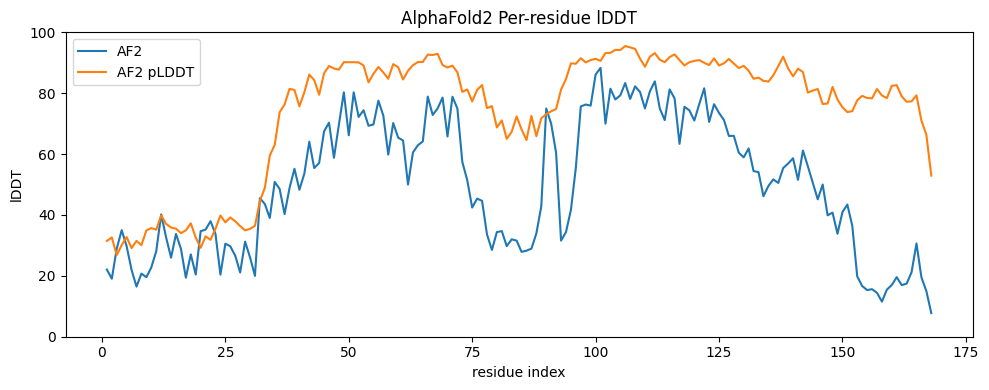

In [65]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10.,4.))
plt.plot(res_ids_AF2, lddt_per_res_AF2*100, label='AF2')  # make sure scale in in percent
plt.plot(res_ids_AF2, plddt_AF2, label='AF2 pLDDT')

plt.title("AlphaFold2 Per-residue lDDT")
plt.xlabel("residue index")
plt.ylabel("lDDT")
plt.ylim(0,100)
plt.legend(loc='best')
plt.tight_layout()

### AlphaFold3 predictions

The code below will compute the *actual* LDDT

The *predicted* pLDDT scores are stored in `AF3_demo/fold_vav_2026_01_31_15_42/fold_vav_2026_01_31_15_42_full_data_0.json`


*First* we will need to convert the *.cif output from AF3 to a PDB

In [66]:
from pathlib import Path
import biotite.structure.io.pdbx as pdbx
import biotite.structure.io.pdb as pdb

def cif_to_pdb_biotite(cif_path: str, pdb_path: str, model: int = 1):
    """
    Convert mmCIF to PDB using Biotite.
    model is 1-based (model=1 means first model).
    """
    cif_path = Path(cif_path)
    pdb_path = Path(pdb_path)

    cif_file = pdbx.CIFFile.read(str(cif_path))
    atoms = pdbx.get_structure(cif_file, model=model)

    pdb_file = pdb.PDBFile()
    pdb_file.set_structure(atoms)
    pdb_file.write(str(pdb_path))
    return pdb_path

cif_AF3 = WORK_DIR / f"AF3_demo/fold_vav_2026_01_31_15_42/fold_vav_2026_01_31_15_42_model_0.cif"
pdb_AF3 = WORK_DIR / f"AF3_demo/fold_vav_2026_01_31_15_42/fold_vav_2026_01_31_15_42_model_0.pdb"

out = cif_to_pdb_biotite(cif_AF3, pdb_AF3, model=1)
print("Wrote:", out)


Wrote: /content/drive/MyDrive/structbio_course/data/assignment01/AF3_demo/fold_vav_2026_01_31_15_42/fold_vav_2026_01_31_15_42_model_0.pdb


/usr/local/lib/python3.12/dist-packages/biotite/structure/io/pdbx/convert.py:461: UserWarning: Attribute 'auth_comp_id' not found within 'atom_site' category. The fallback attribute 'label_comp_id' will be used instead
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/biotite/structure/io/pdbx/convert.py:461: UserWarning: Attribute 'auth_atom_id' not found within 'atom_site' category. The fallback attribute 'label_atom_id' will be used instead
  warnings.warn(


Calculate the *actual* per-residue LDDT scores

In [68]:
ref_path   =  model1_pdb     # <-- your experimental PDB
model_path = pdb_AF3   # <-- your predicted PDB

reference = read_pdb_as_atoms(ref_path, model=1)
model     = read_pdb_as_atoms(model_path, model=1)

# --- Build sequences from structures ---
ref_seq   = struc.to_sequence(reference)[0][0]
model_seq = struc.to_sequence(model)[0][0]

# --- Align sequences to find overlap (robust to differing residue numbering) ---
# Use an identity matrix to avoid "creative" substitutions; good for same protein / close homologs
identity = align.SubstitutionMatrix(
    seq.ProteinSequence.alphabet,
    seq.ProteinSequence.alphabet,
    np.eye(len(seq.ProteinSequence.alphabet), dtype=int),
)

aln = align.align_optimal(
    ref_seq,
    model_seq,
    identity,
    gap_penalty=-1,
    terminal_penalty=False,
    max_number=1,
)[0]

# Keep only aligned columns with residue-residue correspondence (drop gaps)
aln = aln[(aln.trace != -1).all(axis=1)]

# Map alignment columns -> residue indices, then -> atom masks
ref_starts   = struc.get_residue_starts(reference)
model_starts = struc.get_residue_starts(model)

ref_mask = struc.get_residue_masks(reference, ref_starts)[aln.trace[:, 0]].any(axis=0)
mod_mask = struc.get_residue_masks(model,     model_starts)[aln.trace[:, 1]].any(axis=0)

reference_olap = reference[ref_mask]
model_olap     = model[mod_mask]

# For lDDT, it's common to use CA atoms (and it matches the common pLDDT interpretation)
ref_ca = reference_olap[reference_olap.atom_name == "CA"]
mod_ca = model_olap[model_olap.atom_name == "CA"]

# --- Per-residue lDDT ---
lddt_per_res_AF3 = struc.lddt(ref_ca, mod_ca, aggregation="residue")
res_ids_AF3 = np.unique(mod_ca.res_id)

print("Per-residue lDDT (first 10):")
for rid, val in list(zip(res_ids_AF3, lddt_per_res_AF3))[:10]:
    print(rid, f"{val:.3f}")

print("AF3 Global lDDT (mean over residues):", float(np.nanmean(lddt_per_res_AF3)))

Per-residue lDDT (first 10):
1 0.221
2 0.321
3 0.303
4 0.367
5 0.381
6 0.432
7 0.398
8 0.378
9 0.268
10 0.470
AF3 Global lDDT (mean over residues): 0.5493656695265036


Extract the *predicted* per-residue pLDDT scores..

AF3 appears to store only the per-atom scores (super annoying!!!), so we need to parse out the values for the CA atoms only

In [83]:
### 1. Load the per-atom pLDDT values from JSON ########################

import json

json_path = WORK_DIR / f"AF3_demo/fold_vav_2026_01_31_15_42/fold_vav_2026_01_31_15_42_full_data_0.json" # adjust path as needed

with open(json_path, "r") as f:
    data = json.load(f)
per_atom_plddt_AF3 = data['atom_plddts']

print("Total atoms in JSON:", len(per_atom_plddt_AF3))

### 2. Parse the PDB and collect indices of CA atoms ########################

from Bio.PDB import PDBParser


parser = PDBParser(QUIET=True)
structure = parser.get_structure("af3", str(pdb_AF3))

atoms = list(structure.get_atoms())
print("Total atoms in PDB:", len(atoms))

# Sanity check
assert len(atoms) == len(per_atom_plddt_AF3), \
    "Atom count mismatch between PDB and JSON!"

### 3. Extract pLDDT values for CA atoms only ##################

per_res_plddt_AF3 = []
residue_ids_AF3 = []

for atom, plddt in zip(atoms, per_atom_plddt_AF3):
    if atom.get_name() == "CA":
        per_res_plddt_AF3.append(float(plddt))
        res = atom.get_parent()
        hetflag, resseq, icode = res.get_id()
        residue_ids_AF3.append((resseq, icode.strip()))

print("Number of CA atoms:", len(per_res_plddt_AF3))
print("First 10 CA pLDDT values:", per_res_plddt_AF3[:10])


Total atoms in JSON: 1269
Total atoms in PDB: 1269
Number of CA atoms: 168
First 10 CA pLDDT values: [33.42, 29.91, 32.8, 35.3, 38.02, 40.71, 44.75, 45.21, 45.81, 49.56]


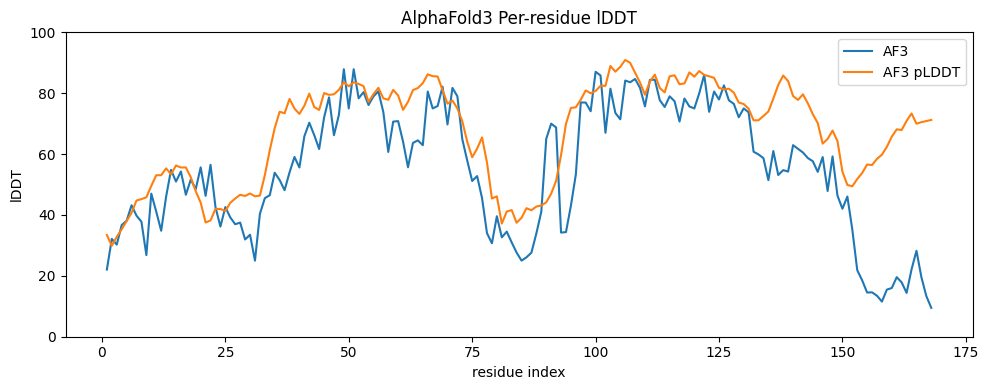

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10.,4.))
plt.plot(res_ids_AF3, lddt_per_res_AF3*100, label='AF3')  # make sure scale in in percent
plt.plot(np.array(res_ids_AF3), per_res_plddt_AF3, label='AF3 pLDDT')

plt.title("AlphaFold3 Per-residue lDDT")
plt.xlabel("residue index")
plt.ylabel("lDDT")
plt.ylim(0,100)
plt.legend(loc='best')
plt.tight_layout()

### ESMFold predictions

The *predicted* pLDDT scores are stored in the B-factor colulm of the PDB `ESMFold_demo/T1027_CASP14_VAV_3b382/ptm0.444_r3_default.pdb`





In [90]:
from Bio.PDB import PDBParser
import pandas as pd
from pathlib import Path

pdb_ESM = WORK_DIR / f"ESMFold_demo/T1027_CASP14_VAV_3b382/ptm0.444_r3_default.pdb"

parser = PDBParser(QUIET=True)
structure = parser.get_structure("esm", str(pdb_ESM))

rows = []
for atom in structure.get_atoms():
    if atom.get_name() != "CA":
        continue
    res = atom.get_parent()
    chain = res.get_parent()

    hetflag, resseq, icode = res.get_id()
    rows.append({
        "chain": chain.id,
        "residue_number": int(resseq),
        "insertion_code": icode.strip(),
        "resname": res.get_resname(),
        "pLDDT": float(atom.get_bfactor()),  # <-- B-factor column
    })

df = pd.DataFrame(rows)
print("CA count:", len(df))
df.head()

print(df["pLDDT"].min(), df["pLDDT"].max())  # should be ~0–100

per_res_plddt_ESM = df["pLDDT"].values
res_ids_ESM = df["residue_number"].values

CA count: 168
27.15 78.5


Calculate the *actual* per-residue LDDT scores

In [94]:
ref_path   =  model1_pdb     # <-- your experimental PDB
model_path = pdb_ESM   # <-- your predicted PDB

reference = read_pdb_as_atoms(ref_path, model=1)
model     = read_pdb_as_atoms(model_path, model=1)

# --- Build sequences from structures ---
ref_seq   = struc.to_sequence(reference)[0][0]
model_seq = struc.to_sequence(model)[0][0]

# --- Align sequences to find overlap (robust to differing residue numbering) ---
# Use an identity matrix to avoid "creative" substitutions; good for same protein / close homologs
identity = align.SubstitutionMatrix(
    seq.ProteinSequence.alphabet,
    seq.ProteinSequence.alphabet,
    np.eye(len(seq.ProteinSequence.alphabet), dtype=int),
)

aln = align.align_optimal(
    ref_seq,
    model_seq,
    identity,
    gap_penalty=-1,
    terminal_penalty=False,
    max_number=1,
)[0]

# Keep only aligned columns with residue-residue correspondence (drop gaps)
aln = aln[(aln.trace != -1).all(axis=1)]

# Map alignment columns -> residue indices, then -> atom masks
ref_starts   = struc.get_residue_starts(reference)
model_starts = struc.get_residue_starts(model)

ref_mask = struc.get_residue_masks(reference, ref_starts)[aln.trace[:, 0]].any(axis=0)
mod_mask = struc.get_residue_masks(model,     model_starts)[aln.trace[:, 1]].any(axis=0)

reference_olap = reference[ref_mask]
model_olap     = model[mod_mask]

# For lDDT, it's common to use CA atoms (and it matches the common pLDDT interpretation)
ref_ca = reference_olap[reference_olap.atom_name == "CA"]
mod_ca = model_olap[model_olap.atom_name == "CA"]

# --- Per-residue lDDT ---
lddt_per_res_ESM = struc.lddt(ref_ca, mod_ca, aggregation="residue")
res_ids_ESM = np.unique(mod_ca.res_id)

print("Per-residue lDDT (first 10):")
for rid, val in list(zip(res_ids_ESM, lddt_per_res_ESM))[:10]:
    print(rid, f"{val:.3f}")

print("ESMFold Global lDDT (mean over residues):", float(np.nanmean(lddt_per_res_ESM)))

Per-residue lDDT (first 10):
1 0.265
2 0.214
3 0.263
4 0.300
5 0.250
6 0.303
7 0.250
8 0.234
9 0.355
10 0.422
ESMFold Global lDDT (mean over residues): 0.4870090451433533


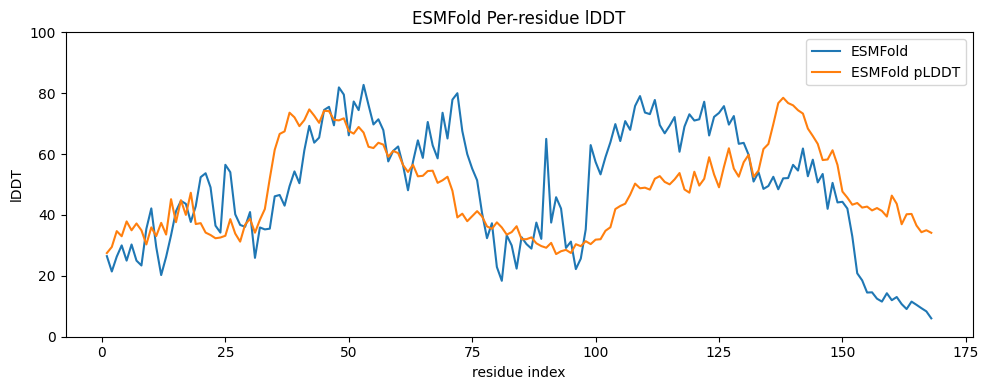

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10.,4.))
plt.plot(res_ids_ESM, lddt_per_res_ESM*100, label='ESMFold')  # make sure scale in in percent
plt.plot(np.array(res_ids_ESM), per_res_plddt_ESM, label='ESMFold pLDDT')

plt.title("ESMFold Per-residue lDDT")
plt.xlabel("residue index")
plt.ylabel("lDDT")
plt.ylim(0,100)
plt.legend(loc='best')
plt.tight_layout()